In [12]:
# Import some libraries we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
import scipy.sparse as sps
from scipy.sparse import csr_matrix
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [13]:
def read_review_data(file_name):
    review_data = pd.read_csv(file_name)
    print "Sample Data"
    print "-----------"
    print review_data.sample(5)
    return review_data

In [14]:
business_data = pd.read_csv('CSV/business.csv')
business_data.head(1)

,hours.Wednesday,attributes.RestaurantsDelivery,attributes.Open24Hours,attributes.DogsAllowed,attributes.CoatCheck,postal_code,attributes.Smoking,hours.Thursday,attributes.DietaryRestrictions,city,...,attributes.RestaurantsAttire,hours.Sunday,attributes.GoodForMeal,attributes.GoodForDancing,attributes.AcceptsInsurance,attributes.RestaurantsReservations,attributes,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating
0,11:0-21:0,False,NaN,NaN,NaN,T2E 6L6,NaN,11:0-21:0,NaN,Calgary,...,casual,NaN,NaN,NaN,NaN,True,"{'BusinessParking': ""{'garage': False, 'street...",True,False,False


In [15]:
business_data.set_index('business_id', inplace = True)

In [16]:
def get_restaurant_data(review_data, business_data):
    review_data['city'] = review_data.apply(lambda x: business_data.loc[x['business_id'], 'city'], axis=1)
    review_data['cat'] = review_data.apply(lambda x: business_data.loc[x['business_id'], 'categories'], axis=1)
    restaurant_reviews = review_data[review_data['cat'].str.contains("Restaurants",na=False)]
    return restaurant_reviews

In [17]:
def get_city_restaurant_data(city, restaurant_reviews):
    city_rest_data = restaurant_reviews.loc[review_data['city'] == city]
    return city_rest_data

In [18]:
review_data = read_review_data('CSV/40core.csv')
print '-----------------------------'
print 'Filtering the Restaurant data'
print '-----------------------------'
restaurant_reviews = get_restaurant_data(review_data, business_data)
print restaurant_reviews.head(3)
print '-----------------------------'
print 'restaurant reviews top 10 cities'
print '-----------------------------'
print restaurant_reviews['city'].value_counts().head(10)
print '-----------------------------'
vegas_40 = get_city_restaurant_data('Las Vegas', restaurant_reviews)

Sample Data
-----------
                      user_id             business_id  stars
9065   3ZCS3niZj8GjbZY6Dx7uqw  wuQDMDlqM17jQNo0lYQZ7g      5
88968  ylNoap5vLFZCPIjwBIdnYA  OK0ba4X5seibH8oMWh4bhw      4
44508  awQhT121Pe0R33sukfTyuA  DkYS3arLOhA8si5uUEmHOw      4
81638  f0TN5yZ7JBMKIzr3hSuwFQ  qsJkjQoM3Hdg6Gtqp2S9_w      4
35093  qPVtjjp8sNQ32p9860SR9Q  BslEhCyzaQPfpHtDogb4hQ      2
-----------------------------
Filtering the Restaurant data
-----------------------------
                  user_id             business_id  stars       city  \
0  AuIK5tF2GjO7SftHawTLKw  I-5qHCVwT7k_KH67-YOx3A      4  Henderson   
2  AuIK5tF2GjO7SftHawTLKw  Zmfq3DVhHdtVChhSxzoUHw      4  Las Vegas   
3  AuIK5tF2GjO7SftHawTLKw  pybIuTluqRhH_BQ3CJHlLw      5  Las Vegas   

                                                 cat  
0  Desserts, Restaurants, American (Traditional),...  
2                                  Restaurants, Thai  
3                                  Thai, Restaurants  
---------------

In [19]:
vegas_40.reset_index(inplace=True)
cols = ['index', 'cat', 'city']
vegas_40.drop(cols, inplace=True, axis=1)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(vegas_40[['user_id', 'business_id', 'stars']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [20]:
#MODEL
svd = SVD(biased=False, lr_all=0.05, n_epochs=10, n_factors=100, reg_all=0.01)
svd_predictions = svd.fit(trainset).test(testset)

In [21]:
sim_options = {'name': 'pearson_baseline',
               'user_based': True  # compute  similarities between users
               }
user = KNNWithMeans(sim_options=sim_options)
user_predictions = user.fit(trainset).test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [22]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
item = KNNWithMeans(sim_options=sim_options)
item_predictions = item.fit(trainset).test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [23]:
print accuracy.mae(svd_predictions)
print accuracy.mae(user_predictions)
print accuracy.mae(item_predictions)

MAE:  0.8307
0.8307155526995048
MAE:  0.7351
0.7350993645969548
MAE:  0.7374
0.7374411733722869


In [24]:
print type(testset)

<type 'list'>


In [25]:
print testset[:5]
print type(svd_predictions[0])
print type(user_predictions[0])
print type(item_predictions[0])

[('LwVUO_5jjHuJRhvl6hlHVg', 'Y07qIurPKiUJDnTZWxZN2A', 1.0), ('SAPltgfFSgI1K9aUuOWcXw', 'Qy_tDaVTWlS14fEglzo1Tg', 4.0), ('YfcXpAQtz0n84aqw_CtNvw', 'R_ZlcX46pPdjhjmfd043LA', 5.0), ('0guV-tXB82pi2stV7a5g5Q', 'JNyho2P0jSk-0T30T3A0OQ', 2.0), ('Hb2RzG3b9YEBlrwBWzGtCA', 'fQt4D34vcJNtEf8Q4zte3w', 4.0)]
<class 'surprise.prediction_algorithms.predictions.Prediction'>
<class 'surprise.prediction_algorithms.predictions.Prediction'>
<class 'surprise.prediction_algorithms.predictions.Prediction'>


In [26]:
res_ls = []
for res in testset:
    res_ls.append(res[2])
res_series = pd.Series(res_ls)    

In [27]:
res_series.head()

0    1.0
1    4.0
2    5.0
3    2.0
4    4.0
dtype: float64

In [28]:
svd_ls = []
for res in svd_predictions:
    svd_ls.append(res.est)
svd_series = pd.Series(svd_ls)

In [29]:
user_ls = []
for res in user_predictions:
    user_ls.append(res.est)
user_series = pd.Series(user_ls)

In [30]:
item_ls = []
for res in item_predictions:
    item_ls.append(res.est)
item_series = pd.Series(item_ls)

In [31]:
merged_df = pd.concat([svd_series, user_series, item_series, res_series], axis=1).reset_index()
merged_df.head()

,index,0,1,2,3
0,0,3.680394,3.300034,3.078641,1.0
1,1,3.060513,3.259720,2.908014,4.0
2,2,3.929246,4.720423,4.431312,5.0
3,3,4.229080,4.473075,4.236791,2.0
4,4,4.530898,4.525300,4.807811,4.0


In [32]:
merged_df.drop(['index'], axis=1, inplace=True)
merged_df.columns = ['svd', 'user', 'item', 'res']
merged_df.head()

,svd,user,item,res
0,3.680394,3.300034,3.078641,1.0
1,3.060513,3.259720,2.908014,4.0
2,3.929246,4.720423,4.431312,5.0
3,4.229080,4.473075,4.236791,2.0
4,4.530898,4.525300,4.807811,4.0


In [33]:
type(merged_df.columns)

pandas.core.indexes.base.Index

In [34]:
from sklearn.model_selection import train_test_split
X = merged_df.drop(['res'], axis=1)
y = merged_df['res']
print X.shape
print y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

(17622, 3)
(17622,)


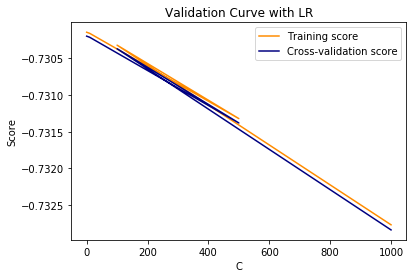

In [38]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge

param_range = [1000, 100, 500, 10, 2, 1, 0.2, 0.1]
est = Ridge()
train_scores, test_scores =  validation_curve(estimator = est, X = X_train, y = y_train, param_name ='alpha',param_range = param_range, cv = 5, scoring = 'neg_mean_absolute_error')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.title("Validation Curve with LR")
plt.xlabel("C")
plt.ylabel("Score")

plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.legend(loc="best")
plt.show()

In [55]:
est = Ridge(alpha = 1000, solver='sag')
est.fit(X_train,y_train)
res = est.predict(X_test)

In [56]:
est.coef_

array([0.1039008 , 0.32313527, 0.28898352])

In [57]:
est.intercept_

1.1013735573795653

In [58]:
from sklearn.metrics import mean_absolute_error
print mean_absolute_error(y_test, res)

0.7184580700262352


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state = 42)

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 5, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
dt_grid = { 'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_search = GridSearchCV(estimator = dt, param_grid = dt_grid, cv = 3, n_jobs = 3, scoring = 'neg_mean_absolute_error')
# Fit the random search model
dt_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_split': [2, 5, 10], 'max_depth': [1, 5, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [47]:
dt_search.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [48]:
dt_new = DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [49]:
dt_new.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [50]:
pred = dt_new.predict(X_test)
print mean_absolute_error(y_test, pred)

0.7240080048988081


In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image

export_graphviz(dt_new, filled=True, rounded=True, special_characters=True)

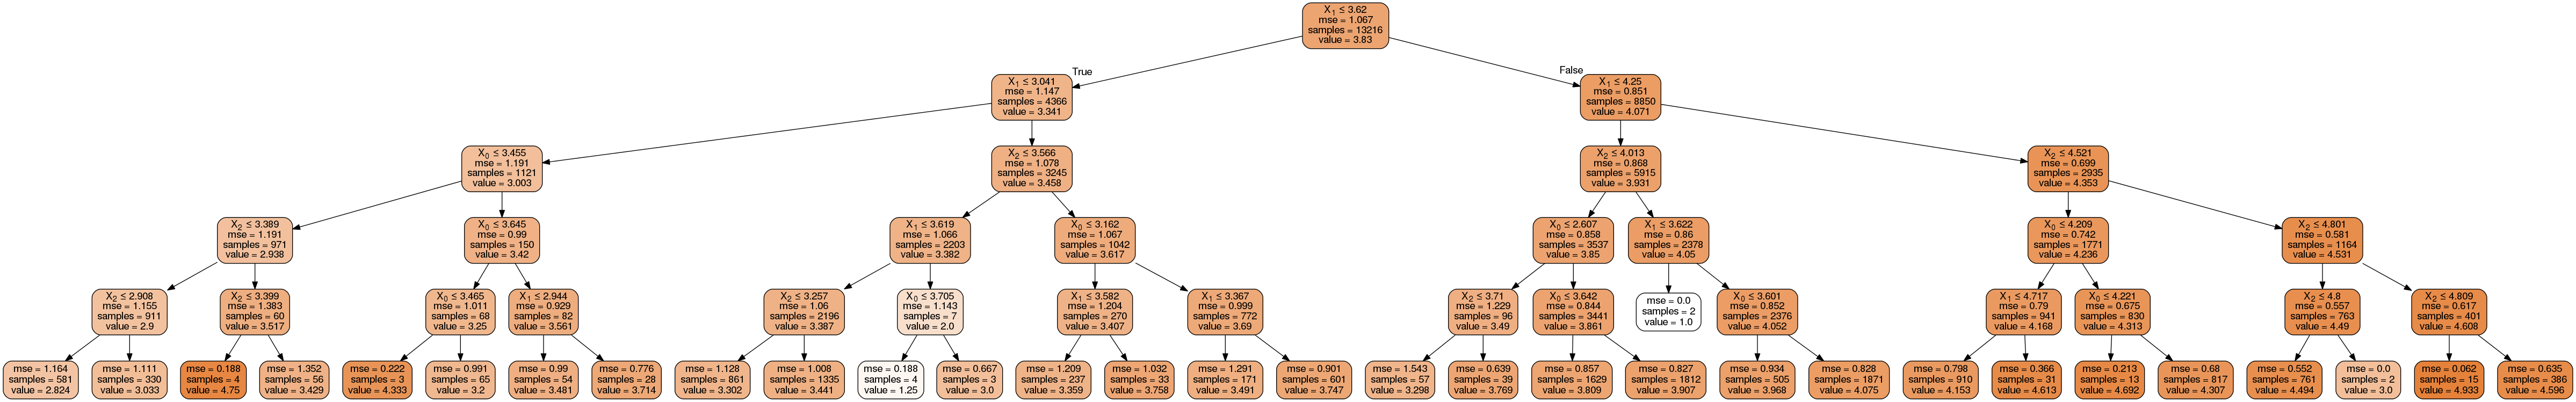

In [52]:
from IPython.display import Image
Image(filename='outfile.png')